##Multi-class Classification

Here we will work on a multi-class classification problem. We will be using the Sign Language MNIST dataset, which contains 28x28 images of hands depicting the 26 letters of the english alphabet.

We will first pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.



In [2]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

First download the datasets

In [3]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:01<00:00, 65.1MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 104MB/s] 


In [4]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Unlike other computer vision projects, here we will not have the actual images, instead we will have the data serialized as csv files.

Take a look at how the data looks like within the csv file:

In [5]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As we can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. 

Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

###Parsing the dataset

parse_data_from_input: This function should be able to read a file passed as input and return 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file. These numpy arrays should have type float64.

A couple of things to keep in mind:

* The first line contains the column headers, so you should ignore it.

* Each successive line contains 785 comma-separated values between 0 and 255

* The first value is the label

* The rest are the pixel values for that picture




In [6]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file
  
  Args:
    filename (string): path to the CSV file
    
  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    labels = []
    images = []

    # Use csv.reader, passing in the appropriate delimiter
    csv_reader = csv.reader(file, delimiter=',')
    tag = 0
    for line in csv_reader:
      if tag:
        label = [0 for _ in range(26)]
        label[int(line[0])] = 1
        labels.append(label)
        arr = np.array(line[1:]).astype('float64')
        arr = arr.reshape(28, 28)
        images.append(arr)
      else:
        tag = 1

    
    return np.array(images), np.array(labels)

In [7]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455, 26) and dtype: int64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172, 26) and dtype: int64


###Visualizing the numpy arrays

Now that we have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like

In [8]:
, training_labels[0]

'training_labels[0]'

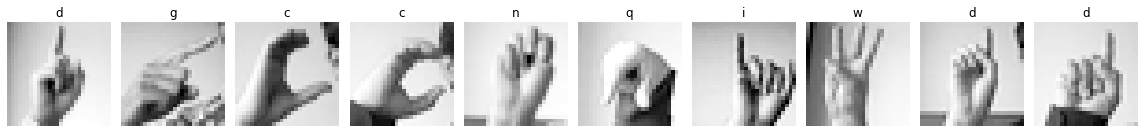

In [9]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[np.argmax(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

###Creating the generators for the CNN

Now that we have successfully organized the data in a way that can be easily fed to Keras' ImageDataGenerator, it is time for us to code the generators that will yield batches of images, both for training and validation. 


Some important notes:

The images in this dataset come in the same resolution so we don't need to set a custom target_size in this case. In fact, we can't even do so because here we will not be using the flow_from_directory method and instead will use the flow method.

We need to add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images).

In [10]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators
  
  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # In this section you will have to add another dimension to the data
  # So, for example, if our array is (10000, 28, 28)
  # We will need to make it (10000, 28, 28, 1)
  training_images = np.expand_dims(training_images, axis=-1)
  validation_images = np.expand_dims(validation_images, axis=-1)

  # Instantiate the ImageDataGenerator class 
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
  # Instantiate the ImageDataGenerator class 
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 


  return train_generator, validation_generator


In [11]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455, 26)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172, 26)


###Coding the CNN

One last step before training is to define the architecture of the model that will be trained.

create_model: This function will return a Keras' model that uses the Sequential or the Functional API.

The last layer of your model should have a number of units that corresponds to the number of possible categories, as well as the correct activation function.

Aside from defining the architecture of the model, we should also compile it so make sure to use a loss function that is suitable for multi-class classification.


In [17]:
from tensorflow.keras.optimizers import RMSprop

def create_model():

  # Define the model
  model = tf.keras.models.Sequential([
      #Adding Convolution and maxpooling layers
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      #Adding dense layers
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(26, activation='softmax')
  ])
  

  model.compile(optimizer = RMSprop(lr=0.01),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  
  return model

In [19]:
# Save our model
model = create_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 512)              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
# Train our model
history = model.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator)

Epoch 1/25
858/858 [==============================] - 48s 54ms/step - loss: 3.1115 - accuracy: 0.1196 - val_loss: 2.2430 - val_accuracy: 0.2670
Epoch 2/25
858/858 [==============================] - 46s 53ms/step - loss: 2.3955 - accuracy: 0.2527 - val_loss: 1.7930 - val_accuracy: 0.4221
Epoch 3/25
858/858 [==============================] - 45s 53ms/step - loss: 2.1447 - accuracy: 0.3276 - val_loss: 1.4552 - val_accuracy: 0.5305
Epoch 4/25
858/858 [==============================] - 45s 53ms/step - loss: 2.0067 - accuracy: 0.3751 - val_loss: 1.4986 - val_accuracy: 0.4852
Epoch 5/25
858/858 [==============================] - 45s 53ms/step - loss: 1.9254 - accuracy: 0.4068 - val_loss: 1.4791 - val_accuracy: 0.5247
Epoch 6/25
858/858 [==============================] - 46s 53ms/step - loss: 1.8629 - accuracy: 0.4255 - val_loss: 1.2615 - val_accuracy: 0.5863
Epoch 7/25
858/858 [==============================] - 47s 55ms/step - loss: 1.8366 - accuracy: 0.4384 - val_loss: 1.2434 - val_accuracy:

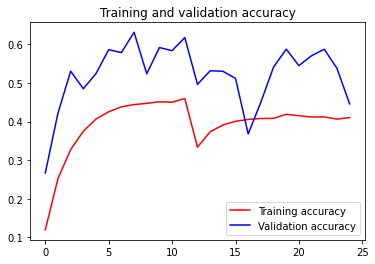

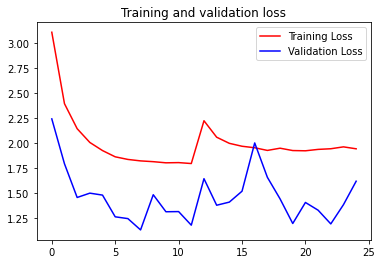

In [21]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Further analysis required to understand the drop in the accuracy at 10th epoch and why underfitting.